In [1]:
import glob
import csv
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt

re_date = re.compile(r'.*/(\d{2})-(\d{2})-(\d{4})_(\d{2})(\d{2})\.csv$')

raw_data = []
for filename in glob.glob("../daily_case_updates/*.csv"):
    m = re_date.match(filename)
    mm,dd,yy,ho,mi = [int(x) for x in m.groups()]
    d = np.datetime64(datetime.datetime(year=yy,month=mm,day=dd,hour=ho,minute=mi))
    with open(filename) as f:
        c = csv.reader(f)
        data = list(c)
        print(d, data[0], len(data))
        raw_data.append((d, data[1:]))
raw_data.sort()

2020-02-02T05:00:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 68
2020-02-02T21:00:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 68
2020-01-23T12:00:00.000000 ['\ufeffProvince/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered', 'Suspected', 'ConfnSusp'] 47
2020-02-11T20:44:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 74
2020-02-09T23:20:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 73
2020-02-09T10:30:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 73
2020-01-28T23:00:00.000000 ['\ufeffProvince/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 53
2020-02-05T12:20:00.000000 ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered'] 71
2020-01-30T11:00:0

In [2]:
def tier(region, country):
    if country != 'Mainland China':
        return 2
    if region != 'Hubei':
        return 1
    return 0

In [3]:
all_regions = set()
for _,d in raw_data:
    for line in d:
        all_regions.add((tier(line[0],line[1]),line[1],line[0]))
print(sorted(all_regions))

[(0, 'Mainland China', 'Hubei'), (1, 'Mainland China', 'Anhui'), (1, 'Mainland China', 'Beijing'), (1, 'Mainland China', 'Chongqing'), (1, 'Mainland China', 'Fujian'), (1, 'Mainland China', 'Gansu'), (1, 'Mainland China', 'Guangdong'), (1, 'Mainland China', 'Guangxi'), (1, 'Mainland China', 'Guizhou'), (1, 'Mainland China', 'Hainan'), (1, 'Mainland China', 'Hebei'), (1, 'Mainland China', 'Heilongjiang'), (1, 'Mainland China', 'Henan'), (1, 'Mainland China', 'Hunan'), (1, 'Mainland China', 'Inner Mongolia'), (1, 'Mainland China', 'Jiangsu'), (1, 'Mainland China', 'Jiangxi'), (1, 'Mainland China', 'Jilin'), (1, 'Mainland China', 'Liaoning'), (1, 'Mainland China', 'Ningxia'), (1, 'Mainland China', 'Qinghai'), (1, 'Mainland China', 'Shaanxi'), (1, 'Mainland China', 'Shandong'), (1, 'Mainland China', 'Shanghai'), (1, 'Mainland China', 'Shanxi'), (1, 'Mainland China', 'Sichuan'), (1, 'Mainland China', 'Tianjin'), (1, 'Mainland China', 'Tibet'), (1, 'Mainland China', 'Xinjiang'), (1, 'Mainlan

In [4]:
dates = np.array([v[0] for v in raw_data], dtype=np.datetime64)
def zeroifempty(x):
    if x=="": return 0
    return int(x)
def cases_by_tier(table, ix):
    c = [0,0,0]
    for line in table:
        t=tier(line[0], line[1])
        c[t]+=zeroifempty(line[ix])
    return c
def summary_by_tier(table):
    return cases_by_tier(table, 3)+cases_by_tier(table, 4)+cases_by_tier(table,5)

In [5]:
summary = np.array([summary_by_tier(v[1]) for v in raw_data])
print(summary)

[[  270    56     6     6     0     0    25     0     0]
 [  444   103     8    17     0     0    28     0     0]
 [  444   195    14    17     1     0    28     2     0]
 [  549   316    16    24     2     0    31     3     0]
 [  549   367    25    24     2     0    31     5     0]
 [  729   591    34    39     2     0    32     6     0]
 [  761   638    39    40     2     0    32     7     0]
 [ 1052   927    40    52     4     0    42     7     0]
 [ 1058  1004    56    52     4     0    42     7     3]
 [ 1423  1314    57    76     4     0    44     7     3]
 [ 1423  1402    61    76     5     0    45    11     3]
 [ 1423  1440    64    76     6     0    45    13     3]
 [ 2714  1695    64   100     7     0    47    13     3]
 [ 2714  1896    80   100     6     0    52    21     6]
 [ 3554  1940    84   125     6     0    80    21     6]
 [ 3554  2416    87   125     7     0    80    24     6]
 [ 3554  2516   103   125     7     0    80    26     6]
 [ 3554  2516    95   125     8

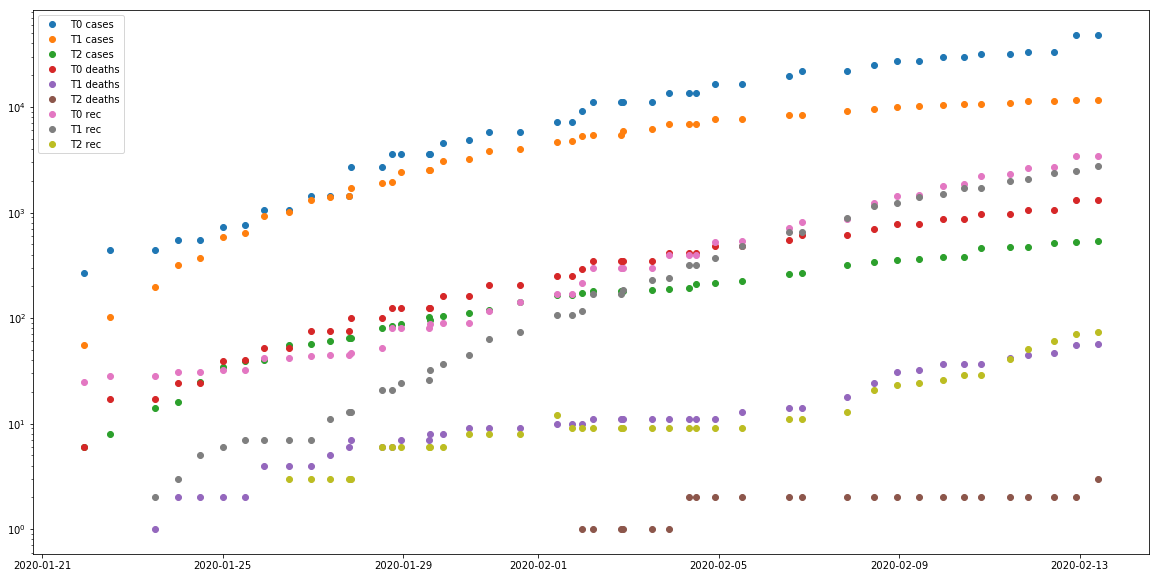

In [6]:
plt.figure(figsize=(20,10))
plt.yscale("log")
plt.plot_date(dates, summary, xdate=True)
plt.legend(["T0 cases", "T1 cases", "T2 cases", "T0 deaths", "T1 deaths", "T2 deaths", "T0 rec", "T1 rec", "T2 rec"])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


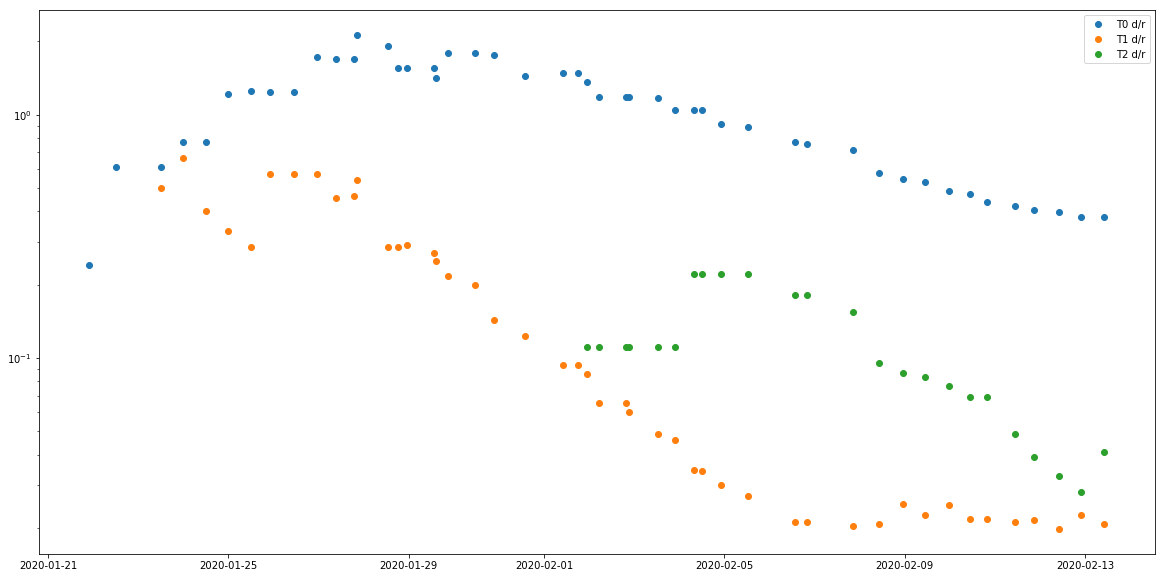

In [7]:
plt.figure(figsize=(20,10))
plt.plot_date(dates, np.array([summary[:,3]/summary[:,6], summary[:,4]/summary[:,7],summary[:,5]/summary[:,8]]).transpose())
plt.yscale("log")
plt.legend(["T0 d/r", "T1 d/r", "T2 d/r"])

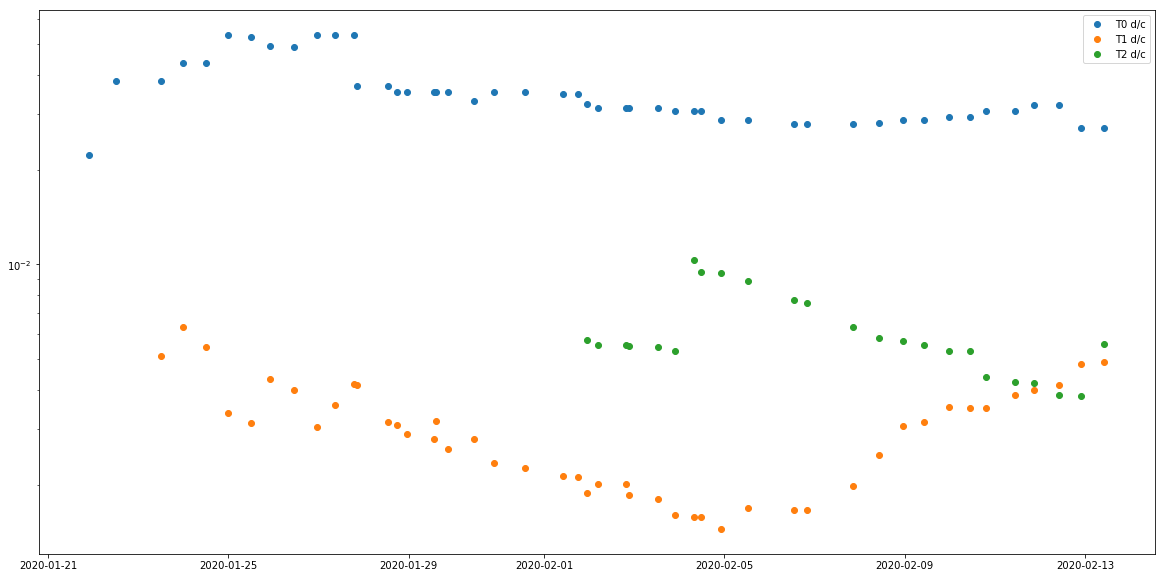

In [8]:
plt.figure(figsize=(20,10))
plt.plot_date(dates, np.array([summary[:,3]/summary[:,0], summary[:,4]/summary[:,1],summary[:,5]/summary[:,2]]).transpose())
plt.yscale("log")
plt.legend(["T0 d/c", "T1 d/c", "T2 d/c"])

In [10]:
print(raw_data[-1][-1])

[['Hubei', 'Mainland China', '2020-02-13 14:13:06', '48206', '1310', '3459'], ['Guangdong', 'Mainland China', '2020-02-13 13:33:01', '1241', '2', '314'], ['Henan', 'Mainland China', '2020-02-13 14:53:02', '1169', '10', '296'], ['Zhejiang', 'Mainland China', '2020-02-13 14:13:06', '1145', '0', '360'], ['Hunan', 'Mainland China', '2020-02-13 11:53:02', '968', '2', '339'], ['Anhui', 'Mainland China', '2020-02-13 13:33:01', '910', '5', '157'], ['Jiangxi', 'Mainland China', '2020-02-13 01:13:08', '872', '1', '170'], ['Jiangsu', 'Mainland China', '2020-02-13 10:33:23', '570', '0', '139'], ['Chongqing', 'Mainland China', '2020-02-13 14:13:06', '525', '3', '128'], ['Shandong', 'Mainland China', '2020-02-13 13:33:01', '509', '2', '105'], ['Sichuan', 'Mainland China', '2020-02-13 13:33:01', '451', '1', '104'], ['Heilongjiang', 'Mainland China', '2020-02-13 12:13:06', '395', '9', '33'], ['Beijing', 'Mainland China', '2020-02-13 14:13:06', '366', '3', '69'], ['Shanghai', 'Mainland China', '2020-02

In [11]:
def extract_region(region, country):
    times, values = [], []
    for t,table in raw_data:
        for line in table:
            if line[0]==region and line[1]==country:
                times.append(t)
                values.append([zeroifempty(x) for x in line[3:6]])
                break
    times = np.array(times, dtype=np.datetime64)
    values = np.array(values)
    return times,values

In [23]:
HB=extract_region('Hubei', 'Mainland China')
GD=extract_region('Guangdong', 'Mainland China')
HA=extract_region('Henan', 'Mainland China')
ZJ=extract_region('Zhejiang', 'Mainland China')
JS=extract_region('Jiangsu', 'Mainland China')

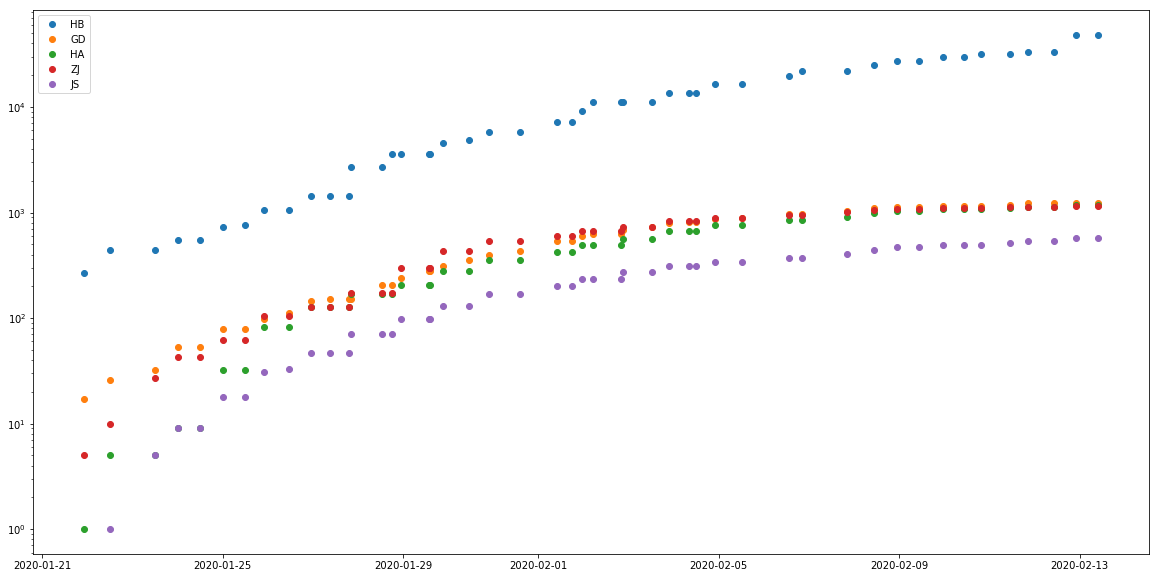

In [24]:
plt.figure(figsize=(20,10))
plt.plot_date(HB[0], HB[1][:, 0])
plt.plot_date(GD[0], GD[1][:, 0])
plt.plot_date(HA[0], HA[1][:, 0])
plt.plot_date(ZJ[0], ZJ[1][:, 0])
plt.plot_date(JS[0], JS[1][:, 0])
plt.yscale("log")
plt.legend(["HB", "GD","HA", "ZJ", "JS"])

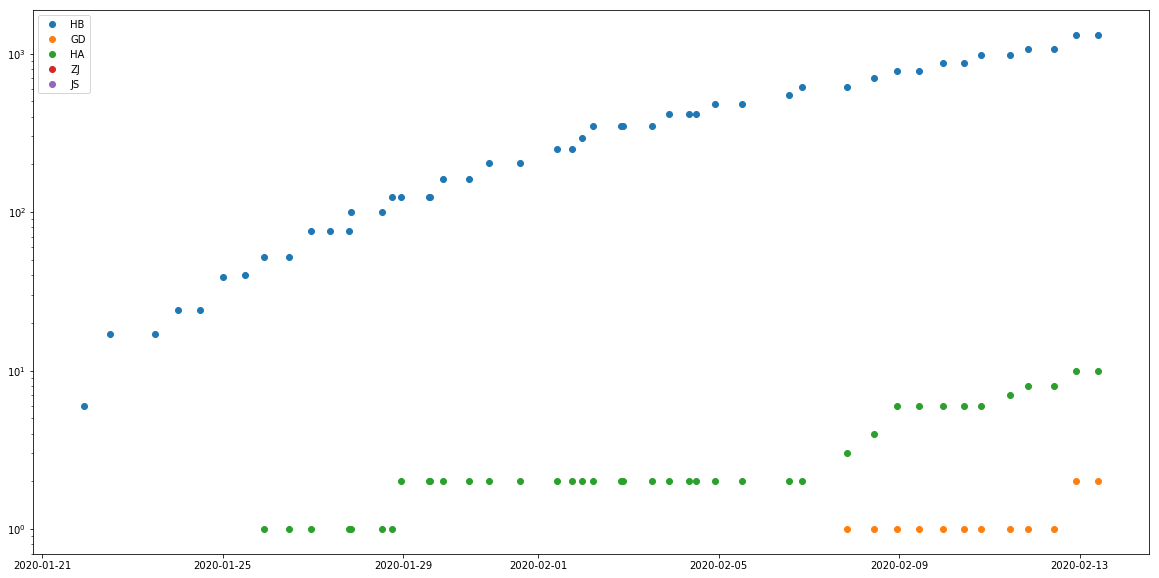

In [25]:
plt.figure(figsize=(20,10))
plt.plot_date(HB[0], HB[1][:, 1])
plt.plot_date(GD[0], GD[1][:, 1])
plt.plot_date(HA[0], HA[1][:, 1])
plt.plot_date(ZJ[0], ZJ[1][:, 1])
plt.plot_date(JS[0], JS[1][:, 1])
plt.yscale("log")
plt.legend(["HB", "GD","HA", "ZJ", "JS"])

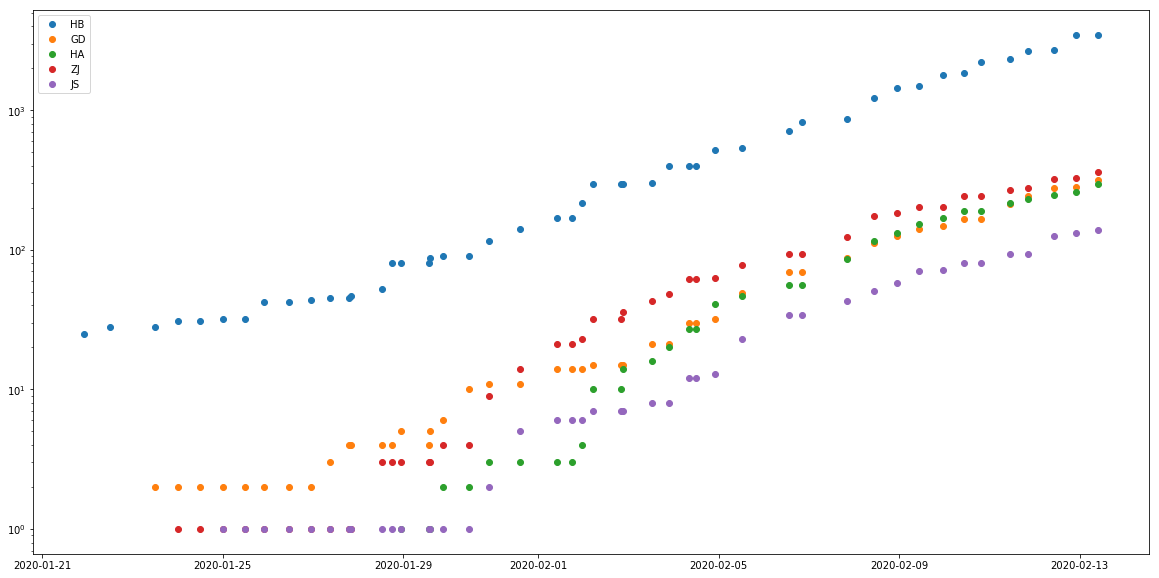

In [26]:
plt.figure(figsize=(20,10))
plt.plot_date(HB[0], HB[1][:, 2])
plt.plot_date(GD[0], GD[1][:, 2])
plt.plot_date(HA[0], HA[1][:, 2])
plt.plot_date(ZJ[0], ZJ[1][:, 2])
plt.plot_date(JS[0], JS[1][:, 2])
plt.yscale("log")
plt.legend(["HB", "GD","HA", "ZJ", "JS"])